In this notebook we will build a classification model using Naive Bayes classifier from python's scikit learn library

## Table of contents
1- Data Loading<BR/>
2- Data Exploration<BR/>
3- Visualization<BR/>
4- Preprocessing<BR/>
5- Bernoulli Naive Bayes model and its variants<BR/>
6- Gaussian Naive Bayes<BR/>
7- Ensemble of Bernoulli and Gaussian model<BR/>
8- Model comparision using ROC curve<BR/>
9- Loading Data<BR/>

##Loading Data
In this section we will import all the necessary packages and load the datasets we plan to work on.<BR/> 
We will use the [Hotel booking](https://www.kaggle.com/jessemostipak/hotel-booking-demand) data and build a model to determine which customers will cancel their hotel booking.<BR/>

In [1]:
# import the libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as pyplot
from pylab import *
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import BernoulliNB
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import recall_score, precision_score, accuracy_score, f1_score
from sklearn.metrics import confusion_matrix, auc, roc_auc_score, roc_curve
import warnings
warnings.filterwarnings('ignore')

In [0]:
# load the data
file_path = 'https://raw.githubusercontent.com/rfordatascience/tidytuesday/master/data/2020/2020-02-11/hotels.csv'
df = pd.read_csv(file_path)

## Explore the dataset
Understanding the data, its features and distribution 

In [310]:
df.head()

,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,meal,country,market_segment,distribution_channel,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,assigned_room_type,booking_changes,deposit_type,agent,company,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date
0,Resort Hotel,0,342,2015,July,27,1,0,0,2,0.0,0,BB,PRT,Direct,Direct,0,0,0,C,C,3,No Deposit,NaN,NaN,0,Transient,0.0,0,0,Check-Out,2015-07-01
1,Resort Hotel,0,737,2015,July,27,1,0,0,2,0.0,0,BB,PRT,Direct,Direct,0,0,0,C,C,4,No Deposit,NaN,NaN,0,Transient,0.0,0,0,Check-Out,2015-07-01
2,Resort Hotel,0,7,2015,July,27,1,0,1,1,0.0,0,BB,GBR,Direct,Direct,0,0,0,A,C,0,No Deposit,NaN,NaN,0,Transient,75.0,0,0,Check-Out,2015-07-02
3,Resort Hotel,0,13,2015,July,27,1,0,1,1,0.0,0,BB,GBR,Corporate,Corporate,0,0,0,A,A,0,No Deposit,304.0,NaN,0,Transient,75.0,0,0,Check-Out,2015-07-02
4,Resort Hotel,0,14,2015,July,27,1,0,2,2,0.0,0,BB,GBR,Online TA,TA/TO,0,0,0,A,A,0,No Deposit,240.0,NaN,0,Transient,98.0,0,1,Check-Out,2015-07-03


In [311]:
df.shape

(119390, 32)

In [312]:
df.dtypes # check the datatype of features

hotel                              object
is_canceled                         int64
lead_time                           int64
arrival_date_year                   int64
arrival_date_month                 object
arrival_date_week_number            int64
arrival_date_day_of_month           int64
stays_in_weekend_nights             int64
stays_in_week_nights                int64
adults                              int64
children                          float64
babies                              int64
meal                               object
country                            object
market_segment                     object
distribution_channel               object
is_repeated_guest                   int64
previous_cancellations              int64
previous_bookings_not_canceled      int64
reserved_room_type                 object
assigned_room_type                 object
booking_changes                     int64
deposit_type                       object
agent                             

We found numbers and categories

In [313]:
df.columns # feature list

Index(['hotel', 'is_canceled', 'lead_time', 'arrival_date_year',
       'arrival_date_month', 'arrival_date_week_number',
       'arrival_date_day_of_month', 'stays_in_weekend_nights',
       'stays_in_week_nights', 'adults', 'children', 'babies', 'meal',
       'country', 'market_segment', 'distribution_channel',
       'is_repeated_guest', 'previous_cancellations',
       'previous_bookings_not_canceled', 'reserved_room_type',
       'assigned_room_type', 'booking_changes', 'deposit_type', 'agent',
       'company', 'days_in_waiting_list', 'customer_type', 'adr',
       'required_car_parking_spaces', 'total_of_special_requests',
       'reservation_status', 'reservation_status_date'],
      dtype='object')

In [314]:
# check for null values
percent_missing = df.isnull().sum() * 100 / len(df)
missing_value_df = pd.DataFrame({'column_name': df.columns, 'percent_missing': percent_missing})
missing_value_df.sort_values('percent_missing', ascending=False, inplace=True)
missing_value_df

,column_name,percent_missing
company,company,94.306893
agent,agent,13.686238
country,country,0.408744
children,children,0.003350
reserved_room_type,reserved_room_type,0.000000
assigned_room_type,assigned_room_type,0.000000
booking_changes,booking_changes,0.000000
deposit_type,deposit_type,0.000000
hotel,hotel,0.000000
previous_cancellations,previous_cancellations,0.000000


Company, agent, country and children have null values.<BR/>
There are multiple techniques for imputing null value but for simplicity 
we impute them with 0.<BR/>
As company has a very high null value percentage 
we will drop the column.

Company has too many null values.

In [0]:
# Let us create a copy of dataframe for backup and impute null with 0
backup_df = df.copy
df = df.drop('company', axis=1)
df = df.fillna(0)

In [316]:
# check that the df has no Null values
(df['agent'].isnull().sum()/len(df)) * 100

0.0

## Data Visualization
In this task, our target variable is is_cancelled 
which indicates if the booking was cancelled.<BR/>
 1 --> canceled, 0 --> Not canceled

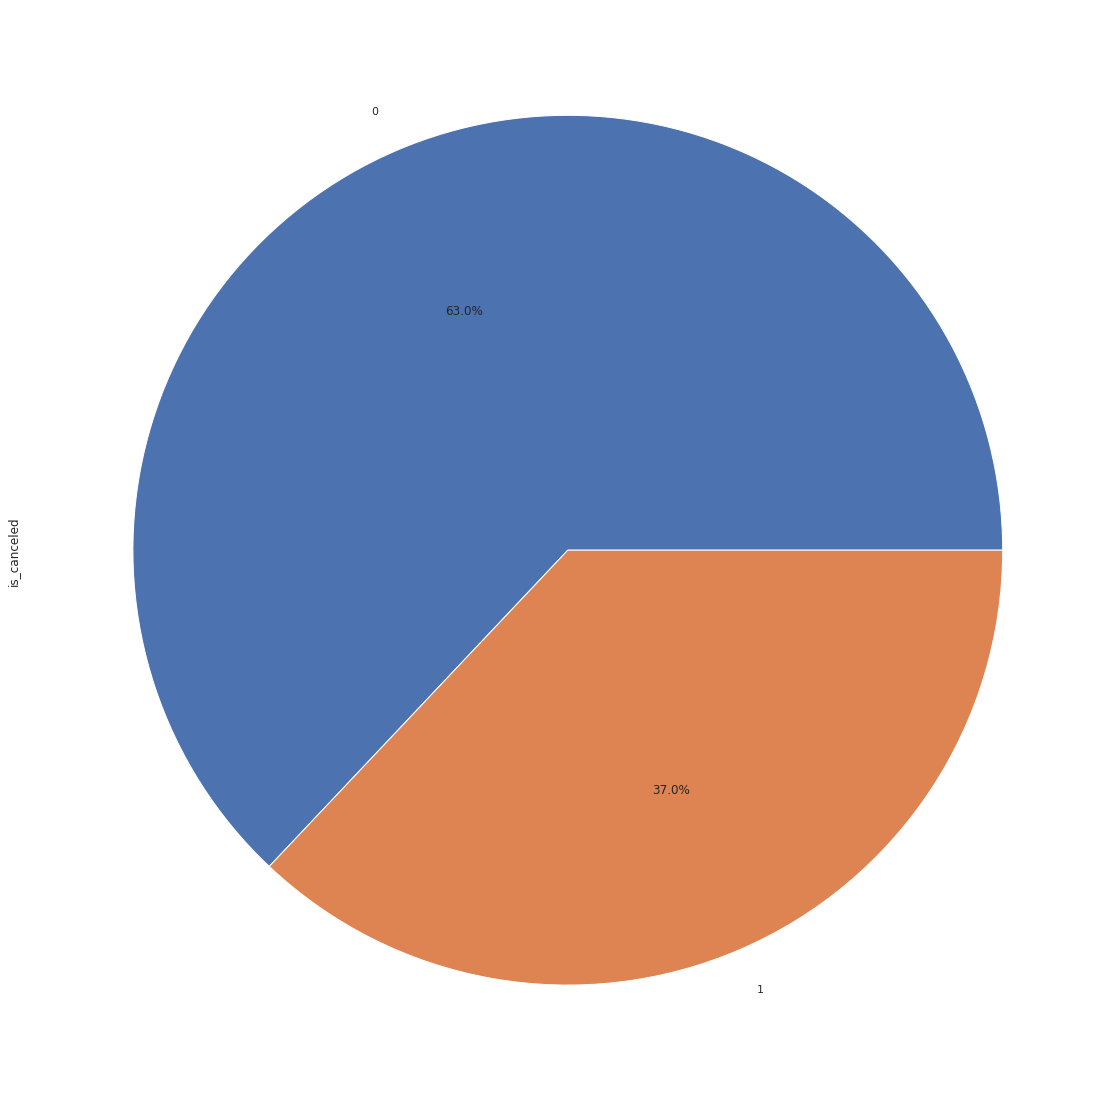

In [317]:
df['is_canceled'].value_counts().plot(kind='pie', autopct='%1.1f%%')

37% customers have cancelled their bookings. Our data in imbalanced.

In [318]:
df.columns

Index(['hotel', 'is_canceled', 'lead_time', 'arrival_date_year',
       'arrival_date_month', 'arrival_date_week_number',
       'arrival_date_day_of_month', 'stays_in_weekend_nights',
       'stays_in_week_nights', 'adults', 'children', 'babies', 'meal',
       'country', 'market_segment', 'distribution_channel',
       'is_repeated_guest', 'previous_cancellations',
       'previous_bookings_not_canceled', 'reserved_room_type',
       'assigned_room_type', 'booking_changes', 'deposit_type', 'agent',
       'days_in_waiting_list', 'customer_type', 'adr',
       'required_car_parking_spaces', 'total_of_special_requests',
       'reservation_status', 'reservation_status_date'],
      dtype='object')

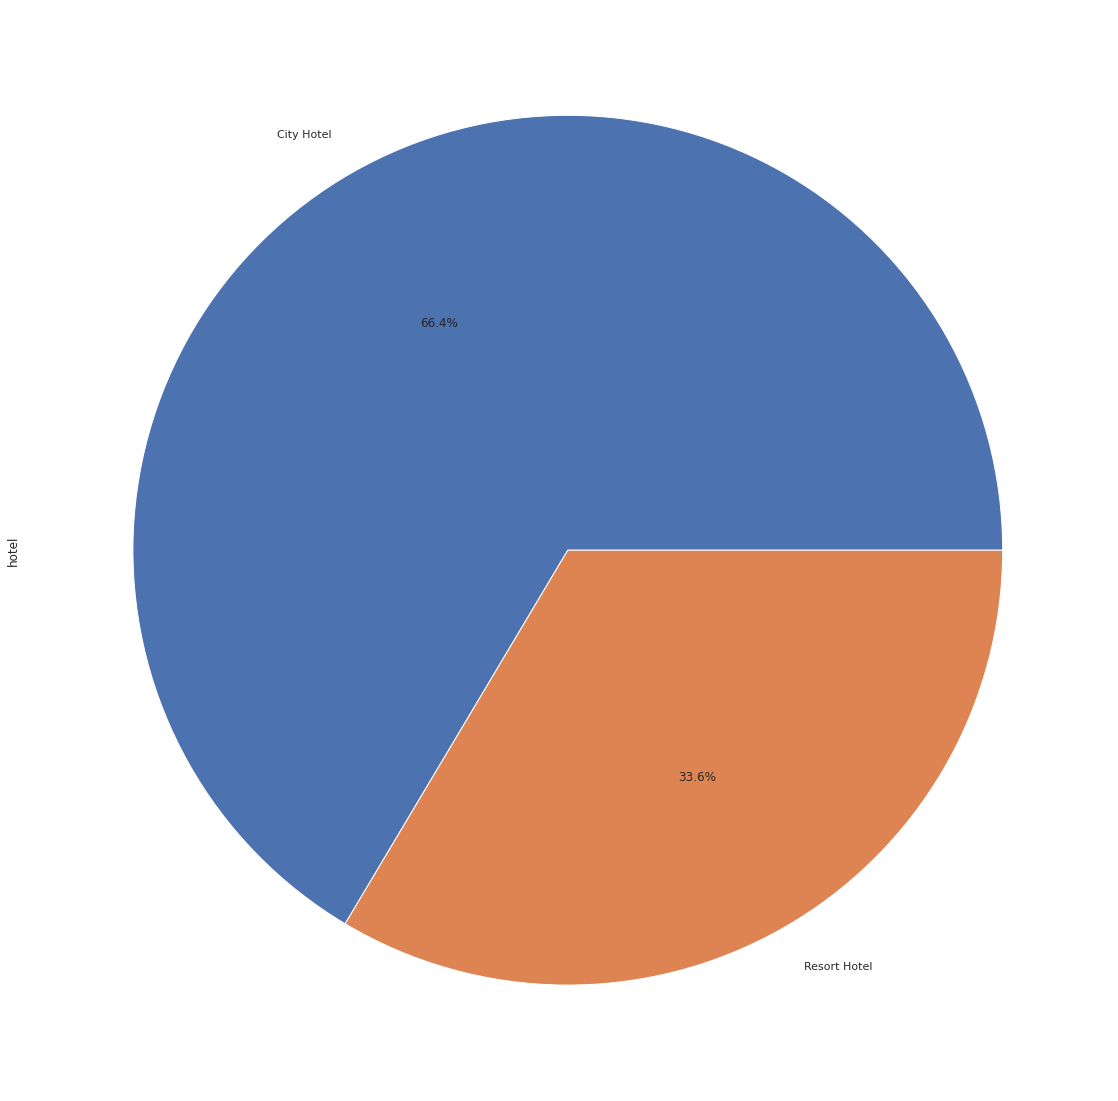

In [319]:
# Hotel feature count and distribution across 0 and 1 class
df['hotel'].value_counts().plot(kind='pie', autopct = '%1.1f%%') 

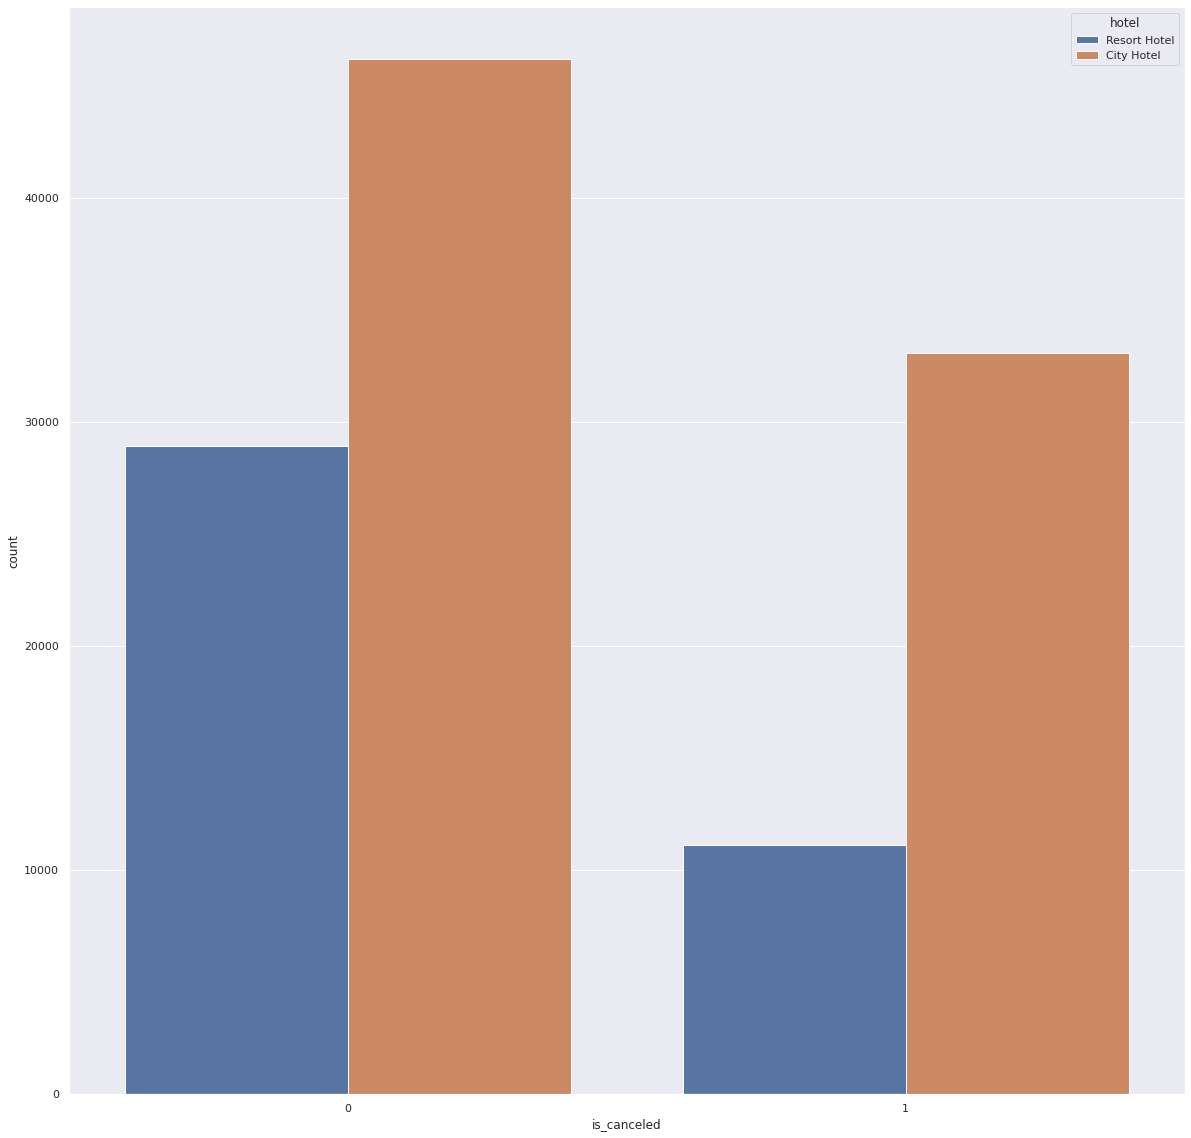

In [320]:
sns.countplot(x='is_canceled', hue='hotel', data = df)

As data has higher city hotel reservation data points compared to resort, above observation is on par with same trend

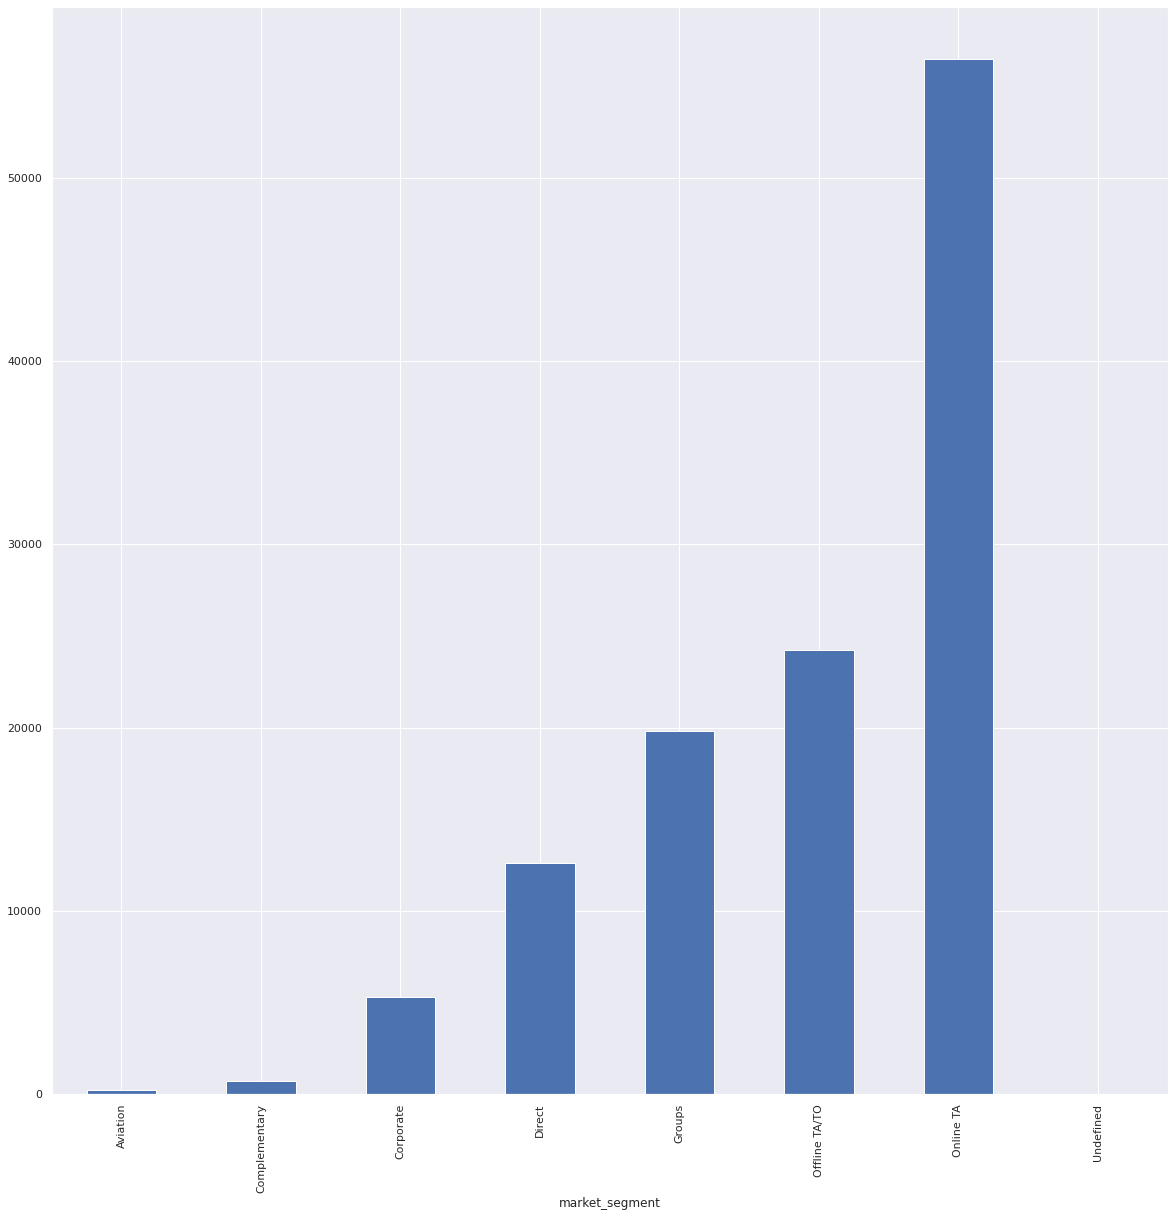

In [321]:
# market segments
df.groupby(['market_segment'])['is_canceled'].count().plot(kind='bar')

## Feature Engineering
1- Derive new features using existing features<BR/>
2- Remove irrelevant features<BR/>
3- Transform existing features<BR/>
4- Encoding categorical variables

In [322]:
# Split data into train test set in train:test=70:30 size
train, test = train_test_split(df, test_size=0.3, random_state = 42)
train.shape

(83573, 31)

In [323]:
test.shape

(35817, 31)

In [0]:
#Let us add weekend stay and weekday stay days to get total days of stay
train['total_days'] = train['stays_in_week_nights'] + train['stays_in_weekend_nights']
test['total_days'] = test['stays_in_week_nights'] + test['stays_in_weekend_nights']
# drop the weekend stay and weekday stay days features
train = train.drop('stays_in_week_nights', axis = 1).drop('stays_in_weekend_nights', axis = 1)

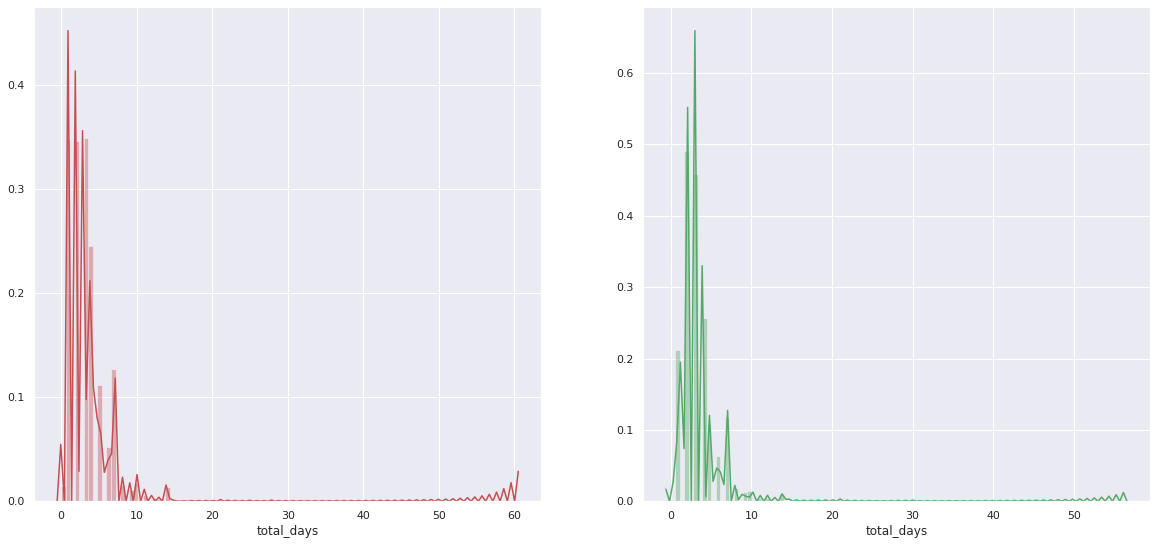

In [325]:
# The most convenient way to take a quick look at a univariate distribution in seaborn is the distplot() function.
train_0 = train[train['is_canceled']==0]
train_1 = train[train['is_canceled']==1]
sns.set(rc ={"figure.figsize":(20,20)})
subplot(2,2,1)
ax = sns.distplot(train_0['total_days'], bins=100, color='r')
subplot(2,2,2)
ax=sns.distplot(train_1['total_days'], bins=100, color= 'g')

In [0]:
# total customers
train['total_customers'] = train['adults'] + train['children'] + train['babies']
test['total_customers'] = test['adults'] + test['children'] + test['babies']

train = train.drop('adults', axis=1).drop('children', axis=1).drop('babies',axis=1)
test = test.drop('adults', axis=1).drop('children', axis=1).drop('babies',axis=1)

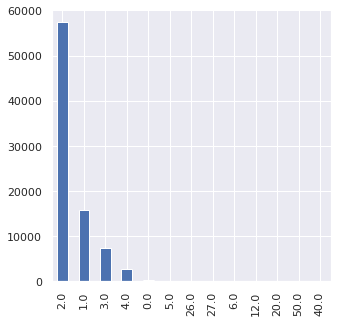

In [327]:
train['total_customers'].value_counts().plot(kind='bar',figsize=(5,5))

In [0]:
train = train.drop(['reservation_status_date'],axis=1)
test = test.drop(['reservation_status_date'],axis=1)

In [329]:
print(len(train['agent'].unique()))  # 314 unique values - Large number of unique agents and it is categorical, difficult to encode
train = train.drop('agent', axis=1)
test = test.drop('agent', axis=1)

314


In [330]:
print(len(train['country'].unique())) # 170 countries
train = train.drop('country', axis=1)
test = test.drop('country', axis=1)

170


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f3fc29cd828>]],
      dtype=object)

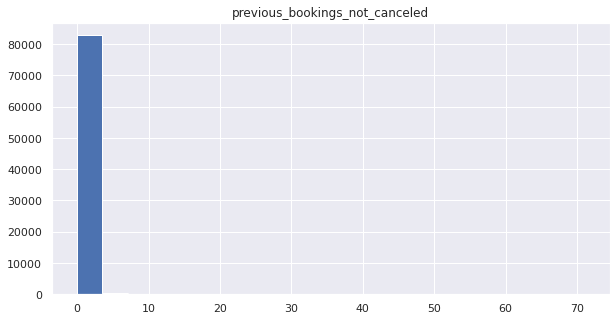

In [331]:
train.hist(column='previous_bookings_not_canceled', bins=20, figsize=(10,5))

`train['previous_bookings_not_canceled'].value_counts()` We observe that most data has value = 0; hence we drop the feature

`train.groupby(['is_canceled'])['previous_bookings_not_canceled'].value_counts()` We observe that data distribution across both class is remains same

In [0]:
train = train.drop('previous_bookings_not_canceled', axis=1)
test = test.drop('previous_bookings_not_canceled', axis=1)

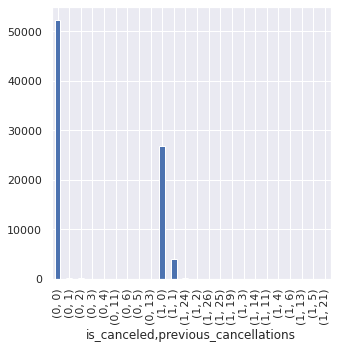

In [333]:
train.groupby(['is_canceled'])['previous_cancellations'].value_counts().plot(kind='bar',figsize=(5,5))
# We observe that most data has value = 0; and trend remains same across the 2 classes
train = train.drop('previous_cancellations',axis=1)
test = test.drop('previous_cancellations', axis=1)

In [334]:
len(train.columns)

23

In [0]:
backup_train = train.copy()
backup_test = test.copy()


## Feature Correlation
We will convert categorical features to numeric values using Label Encoder

In [0]:
# custom encoding
train['arrival_date_month'] = train['arrival_date_month'].map({'January':1, 'February':2, 'March':3, \
                                                          'April':4, 'May':5, 'June':6, 'July':7,\
                                                          'August':8, 'September': 9, 'Octover':10, \
                                                          'November':11, 'December':12})
test['arrival_date_month'] = test['arrival_date_month'].map({'January':1, 'February':2, 'March':3, \
                                                          'April':4, 'May':5, 'June':6, 'July':7,\
                                                          'August':8, 'September': 9, 'Octover':10, \
                                                          'November':11, 'December':12})

In [0]:
encode = LabelEncoder()

In [338]:
train.columns

Index(['hotel', 'is_canceled', 'lead_time', 'arrival_date_year',
       'arrival_date_month', 'arrival_date_week_number',
       'arrival_date_day_of_month', 'meal', 'market_segment',
       'distribution_channel', 'is_repeated_guest', 'reserved_room_type',
       'assigned_room_type', 'booking_changes', 'deposit_type',
       'days_in_waiting_list', 'customer_type', 'adr',
       'required_car_parking_spaces', 'total_of_special_requests',
       'reservation_status', 'total_days', 'total_customers'],
      dtype='object')

In [339]:
train['arrival_date_year'].unique()

array([2016, 2015, 2017])

In [0]:
cat_col=['hotel','arrival_date_year','meal','market_segment','distribution_channel','reserved_room_type', 'assigned_room_type',\
        'deposit_type','customer_type','reservation_status']
for i in cat_col:
    train[i] = encode.fit_transform(train[i])

In [341]:
train[cat_col].head()

,hotel,arrival_date_year,meal,market_segment,distribution_channel,reserved_room_type,assigned_room_type,deposit_type,customer_type,reservation_status
9710,1,1,0,6,3,3,3,0,2,0
40307,0,0,0,4,3,0,0,0,3,0
110051,0,2,0,6,3,3,3,0,2,1
22999,1,2,0,6,3,0,0,0,2,1
8344,1,1,0,6,3,0,0,0,2,0


In [342]:
train['arrival_date_year'].unique()

array([1, 0, 2])

## Feature correlation
Spearman and Pearson are the 2 statistical methods to compute the correlation between features.<BR/>

Pearson is suggested method for features with continuous values and linear relationship.<BR/>
Spearman is suggested method when features have ordinal categorical data or non-linear relationship.<BR/>
Pandas correlation method by default uses Pearson method, but we can also change it to spearman.


In [343]:
train.corr()

,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,meal,market_segment,distribution_channel,is_repeated_guest,reserved_room_type,assigned_room_type,booking_changes,deposit_type,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,total_days,total_customers
hotel,1.000000,-0.135266,-0.075241,-0.035946,0.001268,-0.004423,0.002416,-0.009009,-0.084364,-0.174473,0.051430,0.246741,0.305863,0.070201,-0.155026,-0.071502,-0.047622,-0.099411,0.216490,0.042221,0.123520,0.242948,0.040640
is_canceled,-0.135266,1.000000,0.293248,0.017205,0.008573,0.006479,-0.006537,-0.014264,0.057241,0.166512,-0.085456,-0.059555,-0.173898,-0.140347,0.467354,0.054322,-0.065687,0.047221,-0.194711,-0.237031,-0.915883,0.021257,0.048319
lead_time,-0.075241,0.293248,1.000000,0.038852,0.127818,0.126104,0.002054,0.004313,0.013143,0.220976,-0.123915,-0.107382,-0.173158,0.004114,0.375777,0.170237,0.075026,-0.061618,-0.116425,-0.095988,-0.302591,0.157373,0.073295
arrival_date_year,-0.035946,0.017205,0.038852,1.000000,-0.491213,-0.540726,0.004283,0.067755,0.111935,0.025582,0.007080,0.091785,0.035793,0.030485,-0.065299,-0.057384,-0.005010,0.193542,-0.017678,0.111282,-0.017228,0.030954,0.050789
arrival_date_month,0.001268,0.008573,0.127818,-0.491213,1.000000,0.994852,-0.026792,0.000222,0.013867,0.020514,-0.030665,0.003102,-0.002490,0.006895,-0.013770,0.005842,-0.043188,0.121310,0.005163,0.045114,-0.019068,0.037313,0.047216
arrival_date_week_number,-0.004423,0.006479,0.126104,-0.540726,0.994852,1.000000,0.064206,-0.015267,-0.000917,0.005999,-0.029043,-0.010504,-0.007890,0.004611,0.002251,0.023749,-0.028746,0.077035,0.003264,0.026228,-0.016978,0.016210,0.025711
arrival_date_day_of_month,0.002416,-0.006537,0.002054,0.004283,-0.026792,0.064206,1.000000,-0.007447,-0.004199,0.001474,-0.007002,0.016134,0.012058,0.012223,-0.001229,0.021440,0.011833,0.028831,0.010960,0.003720,0.012448,-0.027971,0.005131
meal,-0.009009,-0.014264,0.004313,0.067755,0.000222,-0.015267,-0.007447,1.000000,0.146540,0.117985,-0.055888,-0.121964,-0.121648,0.019315,-0.090271,-0.007020,0.046316,0.056627,-0.039101,0.024430,0.011251,0.044204,-0.007995
market_segment,-0.084364,0.057241,0.013143,0.111935,0.013867,-0.000917,-0.004199,0.146540,1.000000,0.767718,-0.246093,0.093214,0.024110,-0.072903,-0.184932,-0.043077,-0.166540,0.231270,-0.061893,0.273916,-0.059299,0.126700,0.212585
distribution_channel,-0.174473,0.166512,0.220976,0.025582,0.020514,0.005999,0.001474,0.117985,0.767718,1.000000,-0.258141,-0.042541,-0.105705,-0.114324,0.091225,0.048186,-0.068619,0.093562,-0.132287,0.098250,-0.169993,0.100968,0.144714


Correlation between each and other features goes from -1 to 1. Being 1 the complete correlation.

Other method for correlation.

In [344]:
feat_corr = train.corr()
feat_corr['deposit_type'].sort_values()

reservation_status            -0.464571
total_of_special_requests     -0.266183
assigned_room_type            -0.240921
reserved_room_type            -0.198719
market_segment                -0.184932
hotel                         -0.155026
booking_changes               -0.110863
total_days                    -0.100240
meal                          -0.090271
required_car_parking_spaces   -0.089800
adr                           -0.086046
total_customers               -0.078236
customer_type                 -0.072593
arrival_date_year             -0.065299
is_repeated_guest             -0.057747
arrival_date_month            -0.013770
arrival_date_day_of_month     -0.001229
arrival_date_week_number       0.002251
distribution_channel           0.091225
days_in_waiting_list           0.121999
lead_time                      0.375777
is_canceled                    0.467354
deposit_type                   1.000000
Name: deposit_type, dtype: float64

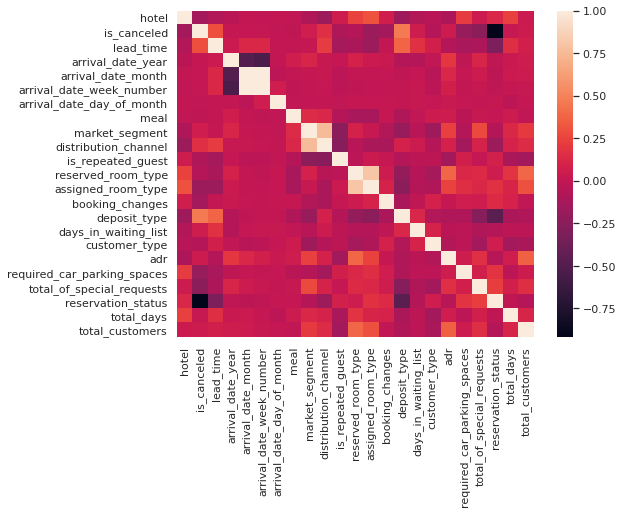

In [345]:

plt.figure(figsize=(8,6))
sns.heatmap(feat_corr)

The diagonal shows correlation of each feature with itself, hence indicates highest correlation. Using the table and plot we observe that few features have veryhigh correlation Ex:-

Arrival_date_year and arrival_date_month = -0.52
Reservation_status and deposit type = -0.46
market_segment vs distribution_channel = 0.76
reserved_room_type vs assigned_room_type = 0.81
It is advisable to remove one of the features from the high correlation pair, but we will retain them and see the effect on performance

In [346]:
feat_corr['is_canceled'].sort_values()

reservation_status            -0.915883
total_of_special_requests     -0.237031
required_car_parking_spaces   -0.194711
assigned_room_type            -0.173898
booking_changes               -0.140347
hotel                         -0.135266
is_repeated_guest             -0.085456
customer_type                 -0.065687
reserved_room_type            -0.059555
meal                          -0.014264
arrival_date_day_of_month     -0.006537
arrival_date_week_number       0.006479
arrival_date_month             0.008573
arrival_date_year              0.017205
total_days                     0.021257
adr                            0.047221
total_customers                0.048319
days_in_waiting_list           0.054322
market_segment                 0.057241
distribution_channel           0.166512
lead_time                      0.293248
deposit_type                   0.467354
is_canceled                    1.000000
Name: is_canceled, dtype: float64

The reservation_status has high correlation with is_canceled. For iteration 1, lets retain the feature.

## Implementing Bernoulli NB
Bernoulli NB classifier works on discrete data with Binary or boolean features. sklearn documentation<BR/>

### Data discretization
Convert continuous features to categorical features

In [0]:
train = backup_train.copy()
test = backup_test.copy()

In [348]:
train.select_dtypes(include=[np.number]).dtypes

is_canceled                      int64
lead_time                        int64
arrival_date_year                int64
arrival_date_week_number         int64
arrival_date_day_of_month        int64
is_repeated_guest                int64
booking_changes                  int64
days_in_waiting_list             int64
adr                            float64
required_car_parking_spaces      int64
total_of_special_requests        int64
total_days                       int64
total_customers                float64
dtype: object

### We will discretize the following continuous features
lead_time - Use quantile<BR/>
arrival_date_week_number - Use Custom bin size<BR/>
days_in_waiting_list - Drop the column<BR/>
adr - Use Quantile<BR/>
required_car_parking_spaces - 0 or more<BR/>
total_of_special_requests - Cap the feature to 3 requests<BR/>
total_customers - Cap the feature to 4 customers<BR/>
total_days - Use quantile

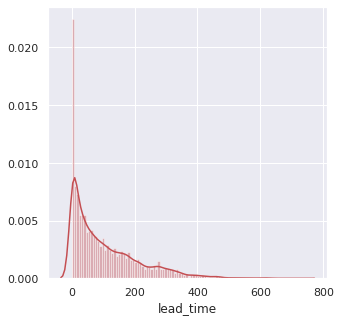

In [349]:
sns.set(rc={"figure.figsize": (5, 5)})
ax = sns.distplot(train['lead_time'], bins=100, color='r')

In [0]:
train['lead_time_q'], bins = pd.qcut(train['lead_time'], q=4,labels=False, retbins=True)
train=train.drop('lead_time',axis=1)
test['lead_time_q']=pd.cut(test['lead_time'], bins=bins,labels=False,precision=0)
test=test.drop('lead_time',axis=1)

In [351]:
train[['lead_time_q']][:5]

,lead_time_q
9710,2
40307,1
110051,2
22999,0
8344,1


array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f3fc25d8080>],
      dtype=object)

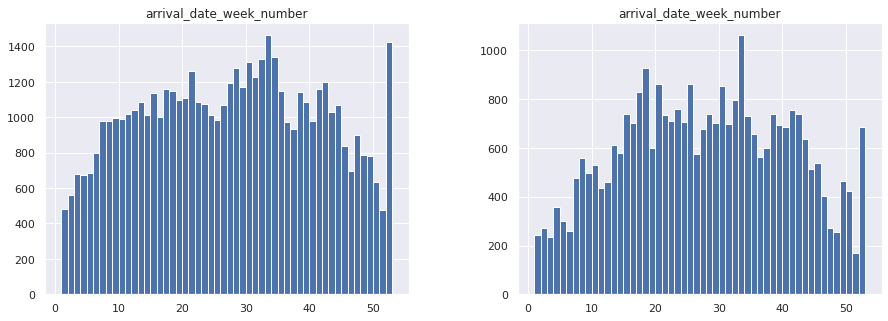

In [352]:
train_0=train[(train['is_canceled']==0)]
train_1=train[train['is_canceled']==1]
fig, axes = plt.subplots(1,2,figsize=(15,5))
train_0.hist(column='arrival_date_week_number',bins=52,ax=axes[0])
train_1.hist(column='arrival_date_week_number', bins=52,ax=axes[1])


In [0]:
bins = [1,13,26,39,53]
train['arrival_date_week_number_q'] = pd.cut(train['arrival_date_week_number'], bins=bins,labels=False)
train=train.drop('arrival_date_week_number',axis=1)
test['arrival_date_week_number_q']=pd.cut(test['arrival_date_week_number'], bins=bins,labels=False)
test=test.drop('arrival_date_week_number',axis=1)

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f3fc2412048>],
      dtype=object)

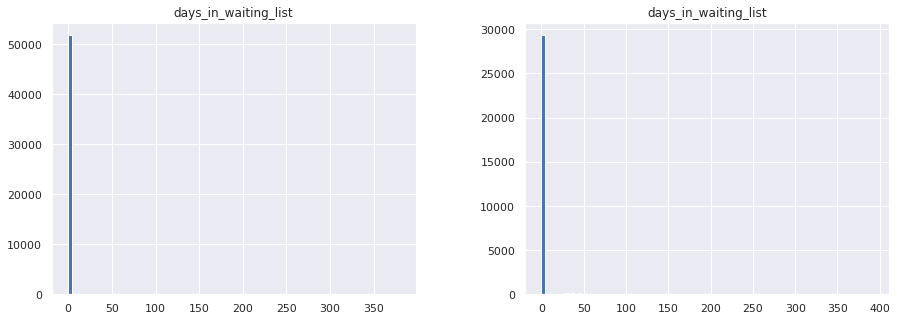

In [354]:
train_O=train[(train['is_canceled']==0)]
train_1=train[train['is_canceled']==1]
fig, axes = plt.subplots(1,2, figsize=(15,5))
train_0.hist(column='days_in_waiting_list',bins=100,ax=axes[0])
train_1.hist(column='days_in_waiting_list',bins=100,ax=axes[1])

In [0]:
train=train.drop('days_in_waiting_list',axis=1)
test=test.drop('days_in_waiting_list',axis=1)

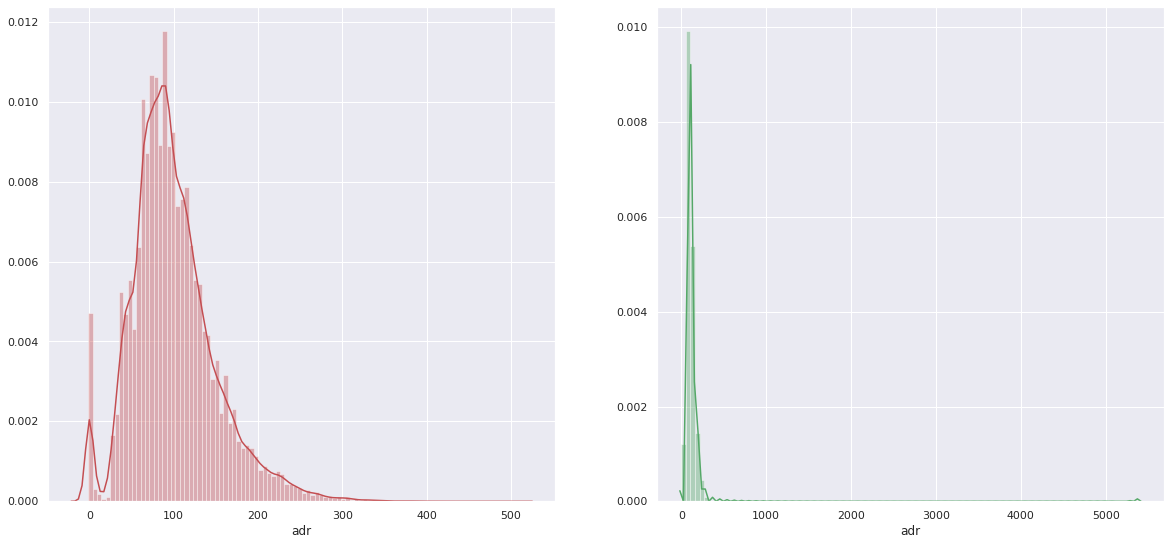

In [356]:
train_0=train[(train['is_canceled']==0)]
train_1=train[train['is_canceled']==1]
sns.set(rc={"figure.figsize": (20,20)})
subplot(2,2,1)
ax = sns.distplot(train_0['adr'], bins=100, color='r')
subplot(2,2,2)
ax=sns.distplot(train_1['adr'],  bins=100, color='g')

In [0]:
train['adr_q'], bins = pd.qcut(train['adr'], q=4,labels=False, retbins=True)
train=train.drop('adr', axis=1)
test['adr_q']=pd.cut(test['adr'], bins=bins, labels=False, precision=0)
test=test.drop('adr', axis=1)


array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f3fc3206a58>],
      dtype=object)

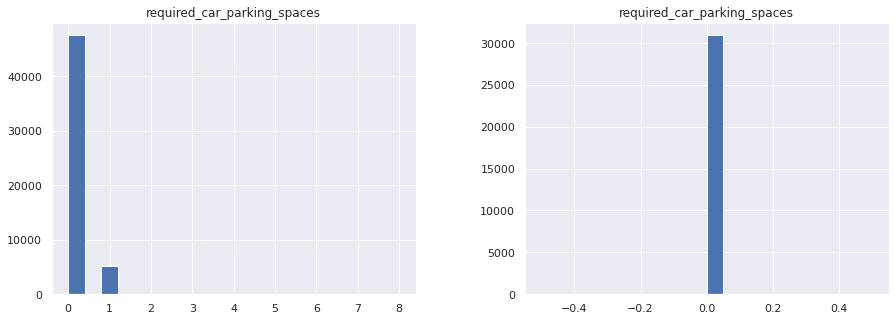

In [358]:
train_0=train[(train['is_canceled']==0)]
train_1=train[train['is_canceled']==1]
fig, axes = plt.subplots(1, 2,figsize=(15,5))
train_0.hist(column='required_car_parking_spaces',bins=20,ax=axes[0])
train_1.hist(column='required_car_parking_spaces',bins=20,ax=axes[1])

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f3fc2c15668>],
      dtype=object)

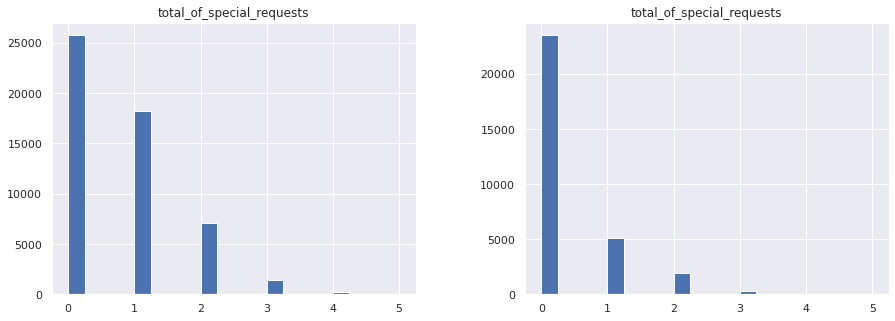

In [359]:
train_0=train[(train['is_canceled']==0)]
train_1=train[train['is_canceled']==1]
fig, axes = plt.subplots(1, 2,figsize=(15,5))
train_0.hist(column='total_of_special_requests',bins=20,ax=axes[0])
train_1.hist(column='total_of_special_requests',bins=20,ax=axes[1])

In [0]:
# train['total_of_special_requests'][train['total_of_special_requests'] >= 3] = 3
# test['total_of_special_requests'][test['total_of_special_requests'] >= 3] = 3

In [0]:
# train['total_days_q'], bins = pd.qcut(train['total_days'], q=4,labels=False, retbins=True)
# train=train.drop('total_days',axis=1)
# test['total_days_q']=pd.cut(test['total_days'], bins=bins,labels=False,precision=0)
# test=test.drop('total_days',axis=1)

In [0]:
# train_0=train[(train['is_canceled']==0)]
# train_1=train[train['is_canceled']==1]
# fig, axes = plt.subplots(1, 2,figsize=(15,5))
# train_0['total_customers'].value_counts().plot('bar',ax=axes[0])
# train_1['total_customers'].value_counts().plot('bar',ax=axes[1])

In [0]:
# train['total_customers'][train['total_customers'] >= 4] = 4
# train['total_customers'][train['total_customers'] <= 0] = 1

# test['total_customers'][test['total_customers'] >= 4] = 4
# test['total_customers'][test['total_customers'] <= 1] = 1

In [0]:
# train_0=train[(train['is_canceled']==0)]
# train_1=train[train['is_canceled']==1]
# fig, axes = plt.subplots(1, 2,figsize=(15,5))
# train_0['arrival_date_day_of_month'].value_counts().plot('bar',ax=axes[0])
# train_1['arrival_date_day_of_month'].value_counts().plot('bar',ax=axes[1])

In [0]:
# train['arrival_date_day_of_month_q'], bins = pd.qcut(train['arrival_date_day_of_month'], q=4,labels=False, retbins=True)
# train=train.drop('arrival_date_day_of_month',axis=1)
# test['arrival_date_day_of_month_q']=pd.cut(test['arrival_date_day_of_month'], bins=bins,labels=False,precision=0)
# test=test.drop('arrival_date_day_of_month',axis=1)

In [0]:
# train

In [0]:
# train.columns

Model 1

In [0]:
# y_train = train["is_canceled"]
# X_train = train.drop(["is_canceled"], axis=1)
# y_test = test["is_canceled"]
# X_test = test.drop(["is_canceled"], axis=1)

In [0]:
# X_train_enc = pd.get_dummies(data=X_train,columns=X_train.columns)
# X_test_enc = pd.get_dummies(data=X_test,columns=X_test.columns)
# X_train_enc,X_test_enc =X_train_enc.align(X_test_enc, join='left', axis=1)
# X_test_enc=X_test_enc.fillna(0)

In [0]:
# X_train_enc[:5]

In [0]:
# clf_bern1 = BernoulliNB()
# clf_bern1.fit(X_train_enc, y_train)

## Parameters
Alpha - Smoothing parameter<BR/>
Binarize - Threshold for binarizing (mapping to booleans) of sample features<BR/>
Fit_prior - Learn class prior probabilities from data or using user provided priors<BR/>
Class_prior - Prior probabilities of the classes. If specified the priors are not adjusted according to the data<BR/>
## Evaluation metric
Precision and Recall<BR/>
Confusion Matrix<BR/>



In [0]:
# y_pred_bern1 = clf_bern1.predict(X_test_enc)
# y_prob_bern1=clf_bern1.predict_proba(X_test_enc)

In [0]:
# y_pred_bern1[:10]

In [0]:
# y_prob_bern1[:10]

In [0]:
# print('test-set confusion matrix:\n', confusion_matrix(y_test,y_pred_bern1)) 
# print("recall score: ", recall_score(y_test,y_pred_bern1))
# print("precision score: ", precision_score(y_test,y_pred_bern1))
# print("f1 score: ", f1_score(y_test,y_pred_bern1))
# # print("accuracy score: ", accuracy_score(y_test,y_pred_bern1))

## Model 2
Remove the feature that is highly correlated with target feature.<BR/>
Reservation_status has high correlation with is_canceled.Looking at the values in column reveals that canceled is a reservation type.This might be causing data leak. Hence we will delete this feature.

In [0]:
# backup_train['reservation_status'].unique(

In [0]:
# X_train = X_train.drop('reservation_status',axis=1)
# X_test = X_test.drop('reservation_status',axis=1)

In [0]:
# X_train_enc = pd.get_dummies(data=X_train,columns=X_train.columns)
# X_test_enc = pd.get_dummies(data=X_test,columns=X_test.columns)
# X_train_enc,X_test_enc =X_train_enc.align(X_test_enc, join='left', axis=1)
# # X_test_enc=X_test_enc.fillna(0)

In [0]:
# clf_bern2 = BernoulliNB()
# clf_bern2.fit(X_train_enc, y_train)
# y_pred_bern2 = clf_bern2.predict(X_test_enc)
# y_prob_bern2=clf_bern2.predict_proba(X_test_enc)
# print('test-set confusion matrix:\n', confusion_matrix(y_test,y_pred_bern2)) 
# print("recall score: ", recall_score(y_test,y_pred_bern2))
# print("precision score: ", precision_score(y_test,y_pred_bern2))
# print("f1 score: ", f1_score(y_test,y_pred_bern2))
# # print("accuracy score: ", accuracy_score(y_test,y_pred_bern2))

In [0]:
# Model 3 -
# Let us remove 1 feature from the correlated feature pair

# Arrival_date_year and arrival_date_month = -0.52
# Reservation_status and deposit type = -0.46
# market_segment vs distribution_channel = 0.76
# # reserved_room_type vs assigned_room_type = 0.81

In [0]:
# X_train = X_train.drop('arrival_date_month',axis=1)
# X_test = X_test.drop('arrival_date_month',axis=1)

# X_train = X_train.drop('market_segment',axis=1)
# X_test = X_test.drop('market_segment',axis=1)

# X_train = X_train.drop('reserved_room_type',axis=1)
# X_test = X_test.drop('reserved_room_type',axis=1)arrival_date_month

In [0]:
# X_train_enc = pd.get_dummies(data=X_train,columns=X_train.columns)
# X_test_enc = pd.get_dummies(data=X_test,columns=X_test.columns)
# X_train_enc,X_test_enc =X_train_enc.align(X_test_enc, join='left', axis=1)
# X_test_enc=X_test_enc.fillna(0)

In [0]:
# clf_bern3 = BernoulliNB()
# clf_bern3.fit(X_train_enc, y_train)

In [0]:
# y_pred_bern3 = clf_bern3.predict(X_test_enc)
# y_prob_bern3=clf_bern3.predict_proba(X_test_enc)
# print('test-set confusion matrix:\n', confusion_matrix(y_test,y_pred_bern3)) 
# print("recall score: ", recall_score(y_test,y_pred_bern3))
# print("precision score: ", precision_score(y_test,y_pred_bern3))
# print("f1 score: ", f1_score(y_test,y_pred_bern3))
# print("accuracy score: ", accuracy_score(y_test,y_pred_bern3))

## Implementing gaussian NB classifier
GaussianNB implements the Gaussian Naive Bayes algorithm for classification. The likelihood of the features is assumed to be Gaussian. sklearn documentation

In [0]:
# train = backup_train.copy()
# test=backup_test.copy()

In [0]:
# train=train.fillna(0)
# test=test.fillna(0)
# y_train = train["is_canceled"]
# X_train =train[['lead_time','arrival_date_week_number','days_in_waiting_list','adr','required_car_parking_spaces',\
#                'total_days','total_of_special_requests','total_customers']]
# y_test = test["is_canceled"]
# X_test = test[['lead_time','arrival_date_week_number','days_in_waiting_list','adr','required_car_parking_spaces',\
#                'total_days','total_of_special_requests','total_customers']]

In [0]:
# classifier2 = GaussianNB()
# classifier2.fit(X_train, y_train)

## Parameters

Priors - Prior probabilities of the classes. If specified the priors are not adjusted according to the data.<BR/>
var_smoothing - Portion of the largest variance of all features that is added to variances for calculation stability.

In [0]:
# y_pred2 = classifier2.predict(X_test)
# y_prob2 = classifier2.predict_proba(X_test)

In [0]:
# print('test-set confusion matrix:\n', confusion_matrix(y_test,y_pred2)) 
# print("recall score: ", recall_score(y_test,y_pred2))
# print("precision score: ", precision_score(y_test,y_pred2))
# print("f1 score: ", f1_score(y_test,y_pred2))
# print("accuracy score: ", accuracy_score(y_test,y_pred2))

## Implementing ensemble of Gaussian and Bernoulli NB
Gaussian NB is trained on continuous feature<BR/>
Bernoulli NB is trained on categorical features<BR/>
The product of probability of both models gives final probability

In [0]:
# backup_train[:5]

In [0]:
# y_train = backup_train["is_canceled"]
# X_train = backup_train.drop(["is_canceled"], axis=1)
# y_test = backup_test["is_canceled"]
# X_test = backup_test.drop(["is_canceled"], axis=1)

In [0]:
# # Basic pre-processing
# X_train['total_customers'][X_train['total_customers'] >= 4] = 4
# X_train['total_customers'][X_train['total_customers'] <= 0] = 1
# X_test['total_customers'][X_test['total_customers'] >= 4] = 4
# X_test['total_customers'][X_test['total_customers'] <= 1] = 1


# X_train['required_car_parking_spaces'][X_train['required_car_parking_spaces'] >= 1] = 1
# X_test['required_car_parking_spaces'][X_test['required_car_parking_spaces'] >= 1] = 1



# X_train['total_of_special_requests'][X_train['total_of_special_requests'] >= 3] = 3
# X_test['total_of_special_requests'][X_test['total_of_special_requests'] >= 3] = 3

In [0]:
# one hot encoding the categorical features
# cat_col=['hotel','arrival_date_year','arrival_date_month','meal','market_segment',\
#           'distribution_channel','reserved_room_type','deposit_type','customer_type','is_repeated_guest',\
#         'total_customers','required_car_parking_spaces','total_of_special_requests']
# d_cat_train=pd.get_dummies(data=X_train[cat_col],columns=cat_col)
# d_cat_test=pd.get_dummies(data=X_test[cat_col],columns=cat_col)

In [0]:
# d_cat_test.shape

In [0]:
# d_cat_train,d_cat_test =d_cat_train.align(d_cat_test, join='left', axis=1)
# d_cat_test=d_cat_test.fillna(0)

In [0]:
# clf_bern = BernoulliNB()
# clf_bern.fit(d_cat_train, y_train)

In [0]:
# d_cont_train=X_train[['lead_time','arrival_date_week_number','days_in_waiting_list','adr','total_days']]
# d_cont_train = d_cont_train.fillna(0)
# d_cont_test = X_test[['lead_time','arrival_date_week_number','days_in_waiting_list','adr','total_days']]
# d_cont_test=d_cont_test.fillna(0)

In [0]:
# clf_gauss = GaussianNB()
# clf_gauss.fit(d_cont_train, y_train)

In [0]:
# y_pred_bern=clf_bern.predict(d_cat_test)
# y_pred_gauss=clf_gauss.predict(d_cont_test)

In [0]:
# y_prob_bern=clf_bern.predict_proba(d_cat_test)
# y_prob_bern_df = pd.DataFrame(data=y_prob_bern,columns=['prob0_b','prob1_b'])
# y_prob_gauss=clf_gauss.predict_proba(d_cont_test)
# y_prob_gauss_df = pd.DataFrame(data=y_prob_gauss,columns=['prob0_g','prob1_g'])

In [0]:
# y_prob=y_prob_bern_df.join(y_prob_gauss_df)

In [0]:
# y_prob['prob0']=y_prob['prob0_b']*y_prob['prob0_g']
# y_prob['prob1']=y_prob['prob1_b']*y_prob['prob1_g']

In [0]:
# y_prob[:10]

In [0]:
# y_prob['prediction']=np.where(y_prob['prob1'] > y_prob['prob0'], 1,0)

In [0]:
# print("Bernoulli f1 score: ", f1_score(y_test,y_pred_bern))
# print("Gaussian f1 score: ", f1_score(y_test,y_pred_gauss))
# print("Ensemble f1 score: ", f1_score(y_test,y_prob['prediction']

In [0]:
## Comparing Gaussian NB and Bernuolli NB

In [0]:
# false_positive_rate4, true_positive_rate4, threshold4 = roc_curve(y_test, y_prob_bern3[:,1])
# roc_auc_bern = auc(false_positive_rate4, true_positive_rate4)

In [0]:
# false_positive_rate, true_positive_rate, threshold = roc_curve(y_test, y_prob2[:,1])
# roc_auc_gauss = auc(false_positive_rate, true_positive_rate)

In [0]:
# plt.figure(figsize = (10,10))
# plt.title('Receiver Operating Characteristic')
# plt.plot(false_positive_rate, true_positive_rate, color = 'red', label = 'Gauss AUC = %0.2f' % roc_auc_gauss)
# plt.plot(false_positive_rate4, true_positive_rate4, color = 'green', label = 'Bern AUC = %0.2f' % roc_auc_bern)
# plt.legend(loc = 'lower right')
# plt.plot([0, 1], [0, 1], linestyle = '--')
# plt.axis('tight')
# plt.ylabel('True Positive Rate')
# plt.xlabel('False Positive Rate')

## Other references:
[seaborn-distplot](https://seaborn.pydata.org/tutorial/distributions.html)
